In [ ]:
# data
# https://www.kaggle.com/chrisfilo/fruit-recognition

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import seaborn as sns
import cv2
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display

In [ ]:
# gettiong images

In [ ]:
import os 


In [ ]:
os.listdir('/content/drive/MyDrive/диплом/data')
my_data_dir = '/content/drive/MyDrive/диплом/data'

In [ ]:
fruits_names = ['Apple','Banana','Carambola','Persimmon','Peach','muskmelon','Guava','Mango','Pear','Orange',
                'Kiwi','Pomegranate','Plum','Tomatoes','Pitaya']

In [ ]:
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [ ]:
images = []
for f in os.listdir(my_data_dir):
    if "png" in os.listdir(my_data_dir+'/'+f)[0]:
        images += load_images_from_folder(my_data_dir+'/'+f,True,label = f)
    else: 
        for d in os.listdir(my_data_dir+'/'+f):
            images += load_images_from_folder(my_data_dir+'/'+f+"/"+d,True,label = f)
            
# Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["fruit", "path"])

In [ ]:
# Shuffle the dataset
from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

# Visualize the resulting dataframe
df.head()

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


,fruit,path,label
0,Pomegranate,/content/drive/MyDrive/диплом/data/Pomegranate...,12
1,Tomatoes,/content/drive/MyDrive/диплом/data/Tomatoes/Ta...,13
2,Guava,/content/drive/MyDrive/диплом/data/Guava/Guava...,3
3,Plum,/content/drive/MyDrive/диплом/data/Plum/PlumуА...,11
4,Kiwi,/content/drive/MyDrive/диплом/data/Kiwi/Kiwi C...,4


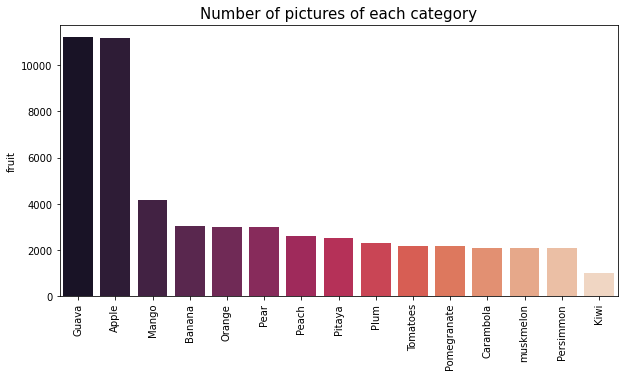

In [ ]:
# Display the number of pictures of each category
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

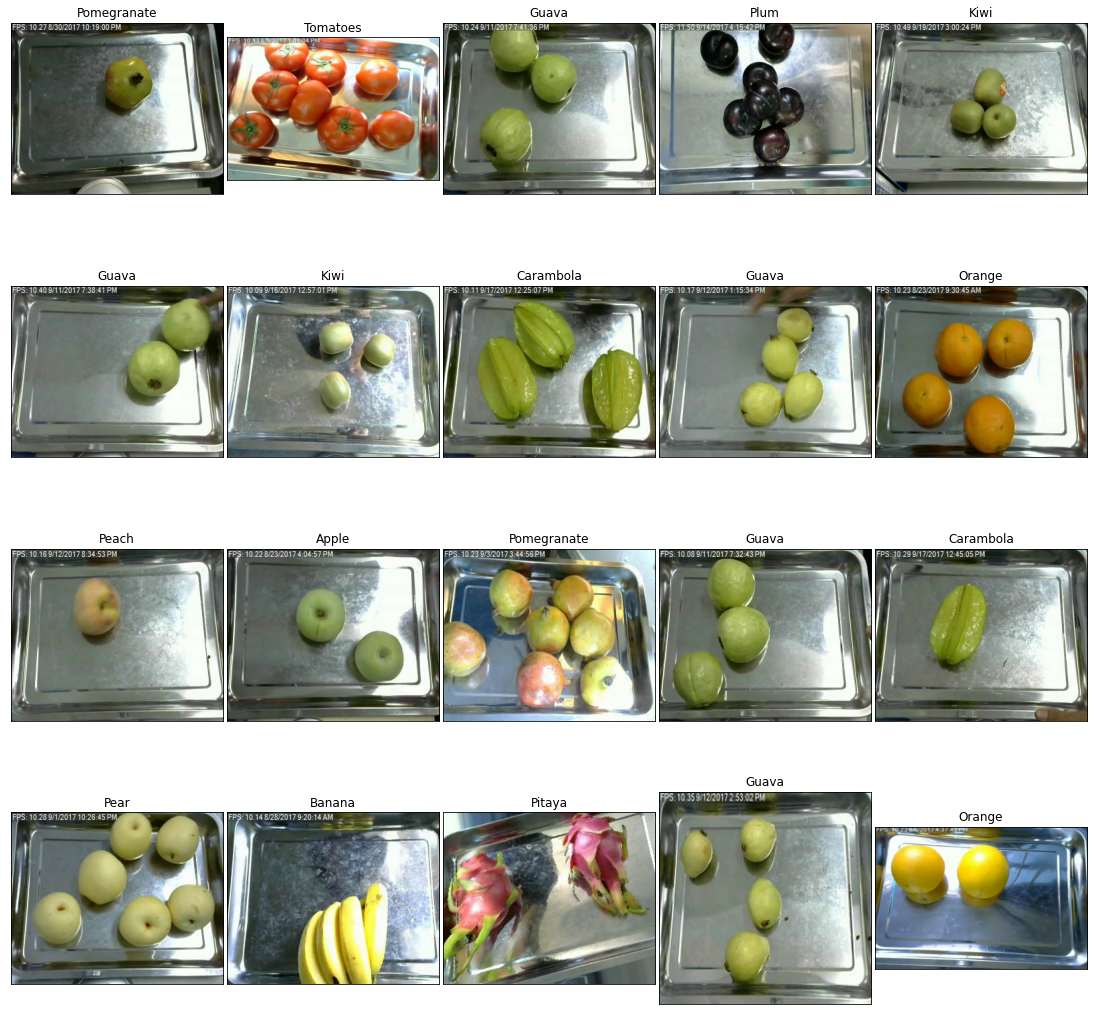

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

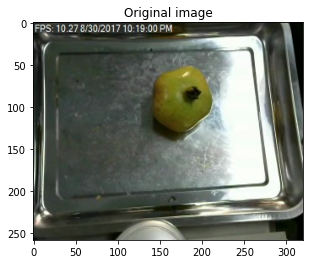

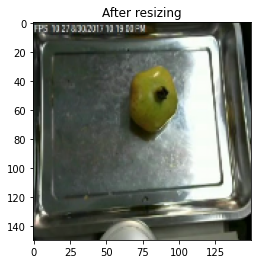

In [ ]:
# The pictures will be resized to have the same size for the neural network
img = plt.imread(df.path[0])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

In [ ]:

def cut_df(df, number_of_parts, part):
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

In [ ]:
def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [ ]:
def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [ ]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [ ]:
model = create_model()
hists = []

# The model will be trained with one part of the data.
# There isn't enough RAM on Kaggle to handle all the data.
# In the next chapter a generator will be used
# to "feed" the ANN step by step.
# For Kaggle set divisor <= 5. 1/5 of the data will be used
divisor = 5

#start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)



TypeError: ignored

In [ ]:
# If the ANN doesn't increase its prediction accuracy on the validation data after 
# 10 epochs, stop the training and take the best of the ANN.
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

Epoch 1/100
77/77 [==============================] - 362s 5s/step - loss: 2.5232 - accuracy: 0.2165 - val_loss: 2.4055 - val_accuracy: 0.2388
Epoch 2/100
77/77 [==============================] - 356s 5s/step - loss: 2.3513 - accuracy: 0.2624 - val_loss: 2.2283 - val_accuracy: 0.2992
Epoch 3/100
77/77 [==============================] - 357s 5s/step - loss: 2.0268 - accuracy: 0.3391 - val_loss: 1.8465 - val_accuracy: 0.3275
Epoch 4/100
77/77 [==============================] - 359s 5s/step - loss: 1.5209 - accuracy: 0.4746 - val_loss: 1.0077 - val_accuracy: 0.6359
Epoch 5/100
77/77 [==============================] - 354s 5s/step - loss: 1.1217 - accuracy: 0.6396 - val_loss: 0.9679 - val_accuracy: 0.6468
Epoch 6/100
77/77 [==============================] - 351s 5s/step - loss: 0.8603 - accuracy: 0.6994 - val_loss: 0.5203 - val_accuracy: 0.8079
Epoch 7/100
77/77 [==============================] - 352s 5s/step - loss: 0.6047 - accuracy: 0.7844 - val_loss: 0.4130 - val_accuracy: 0.8481
Epoch 

In [ ]:


# Run the garbage collector
gc.collect()



11446

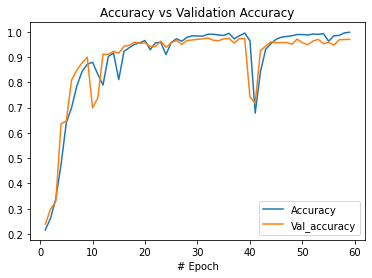

In [ ]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [ ]:


import warnings
warnings.filterwarnings("ignore")

# Make predictions with the model using the last 1/20 part of the dataset
X, y = load_img(cut_df(df, 20, 20))



In [ ]:
#pred = model.predict_classes(X)
predict_x=model.predict(X) 
pred=np.argmax(predict_x,axis=1)
y_test = to_categorical(y)

# Display statistics
#display_stats(y_test, pred)


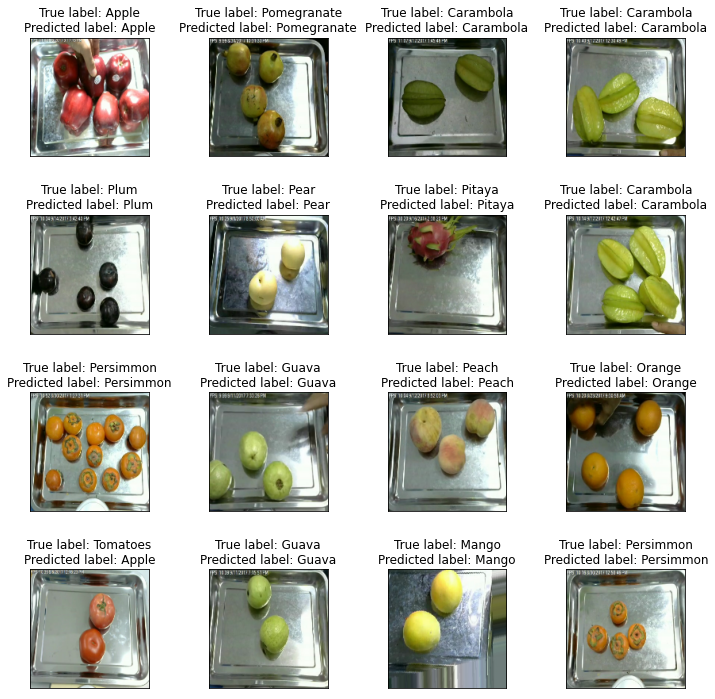

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()

